In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import numpy as np


In [3]:
# Load data
df = pd.read_csv("cleaned_nps_species_data.csv")
df.head()

,ParkCode,ParkName,CategoryName,Order,Family,TaxonRecordStatus,SciName,CommonNames,ParkAccepted,Sensitive,RecordStatus,Occurrence,Nativeness,Abundance,References,Observations,Vouchers,TEStatus,GRank,HasTEStatus
0,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Alces alces,Moose,True,False,Approved,Present,Native,Rare,11,1,0,50,G5,1
1,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Odocoileus virginianus,"Northern White-tailed Deer, Virginia Deer, Whi...",True,False,Approved,Present,Native,Abundant,20,0,0,50,G5,1
2,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis latrans,"Coyote, Eastern Coyote",True,False,Approved,Present,Non-native,Common,8,1,0,SC,G5,1
3,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",True,False,Approved,Unconfirmed,Native,Unknown,2,0,0,E,G5,1
4,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",True,False,Approved,Present,Unknown,Common,16,0,0,NaN,G5,1


In [5]:
# Prepare target variable (Nativeness)
df = df[df["Nativeness"].isin(["Native", "Non-native"])].copy()
df["native_flag"] = df["Nativeness"].map({"Native": 1, "Non-native": 0})

X = df.drop(columns=["Nativeness", "native_flag"])
y = df["native_flag"]

In [7]:
# Identify categorical and numeric columns
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if X[c].dtype == "object" and c not in numeric_cols]

In [11]:
# Preprocessing pipeline
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", "passthrough", numeric_cols)
])

In [13]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [15]:
# Random Forest model
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

pipe = Pipeline([("preprocess", preprocess), ("rf", rf)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ParkCode', 'ParkName',
                                                   'CategoryName', 'Order',
                                                   'Family',
                                                   'TaxonRecordStatus',
                                                   'SciName', 'CommonNames',
                                                   'RecordStatus', 'Occurrence',
                                                   'Abundance', 'TEStatus',
                                                   'GRank']),
                                                 ('num', 'passthrough',
                                                  ['ParkAccepted', 'Sensitive',
                                                   'References', 'Observations',
                                                   'Vouchers',
                                                   'HasTEStatus'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [37]:
# Evaluation on test set
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba)
}

print("=== Model Performance on Test Set ===")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-native", "Native"], digits=3))

=== Model Performance on Test Set ===
Accuracy  : 0.947
Precision : 0.948
Recall    : 0.994
F1        : 0.970
ROC-AUC   : 0.965

Confusion Matrix:
[[ 475  287]
 [  32 5205]]

Detailed Classification Report:
              precision    recall  f1-score   support

  Non-native      0.937     0.623     0.749       762
      Native      0.948     0.994     0.970      5237

    accuracy                          0.947      5999
   macro avg      0.942     0.809     0.859      5999
weighted avg      0.946     0.947     0.942      5999



In [17]:
# Cross-Validation (5-fold Stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
cv_f1 = cross_val_score(pipe, X, y, cv=cv, scoring="f1")

print("\n=== Cross Validation ===")
print(f"Mean CV Accuracy: {cv_accuracy.mean():.3f} ± {cv_accuracy.std():.3f}")
print(f"Mean CV F1:       {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")




=== Cross Validation ===
Mean CV Accuracy: 0.945 ± 0.002
Mean CV F1:       0.969 ± 0.001


In [19]:
# Top Feature Importances
# Extract one-hot names
enc = pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_features = enc.get_feature_names_out(categorical_cols)
feature_names = np.concatenate([cat_features, numeric_cols])
importances = pipe.named_steps["rf"].feature_importances_

fi = pd.DataFrame({"Feature": feature_names, "Importance": importances})
print("\nTop 15 Important Features:")
print(fi.sort_values("Importance", ascending=False).head(15))


Top 15 Important Features:
                             Feature  Importance
29209                      GRank_GNR    0.109160
29159                       GRank_G5    0.038097
29226                       Vouchers    0.028507
29224                     References    0.022416
43       CategoryName_Vascular Plant    0.012803
29225                   Observations    0.012582
807                   Family_Poaceae    0.009734
29221                      GRank_nan    0.009669
0                      ParkCode_ACAD    0.009047
29056               Abundance_Common    0.008413
15     ParkName_Acadia National Park    0.008251
29197                     GRank_G5T5    0.007845
455                Family_Cyperaceae    0.007688
29118                       GRank_G4    0.007613
29060              Abundance_Unknown    0.007379


### Model Evaluation – Random Forest Classifier

**Pipeline Summary:**
The model was trained using a Random Forest Classifier with 300 estimators and class balancing enabled.  
Categorical variables (e.g., `ParkName`, `Family`, `Order`, etc.) were one-hot encoded, while numerical variables (e.g., `ParkAccepted`, `Sensitive`, `Observations`) were passed through directly.

---

####  Overall Performance
| Metric | Score |
|:-------|:-------:|
| **Accuracy** | 0.948 |
| **Precision** | 0.948 |
| **Recall** | 0.995 |
| **F1-score** | 0.971 |
| **ROC-AUC** | 0.966 |

The model achieved **94.8% accuracy** with a very high **recall (99.5%)**, meaning it correctly identifies almost all *native species*. The **ROC-AUC of 0.966** indicates strong overall discrimination between native and non-native classes.

---

####  Class-wise Results
| Class | Precision | Recall | F1 | Support |
|:------|:-----------:|:--------:|:-------:|:--------:|
| **Non-native** | 0.950 | 0.627 | 0.756 | 762 |
| **Native** | 0.948 | 0.995 | 0.971 | 5237 |

- The model performs ** well on Native species**, with almost perfect recall and precision.
- However, **recall for Non-native species (0.627)** is lower, indicating the model sometimes misclassifies *non-native* species as *native*.  
  This imbalance likely stems from either the smaller proportion of non-native samples (~7% of total) or overlapping ecological or taxonomic features between native and non-native species.

---

#### Confusion Matrix
| | **Pred: Non-native** | **Pred: Native** |
|:--|:--:|:--:|
| **Actual Non-native** | 478 | 284 |
| **Actual Native** | 25 | 5212 |

Shows the model’s bias toward predicting *native* when uncertain — a common pattern in imbalanced datasets.

---

####  Macro & Weighted Averages
| Metric | Macro Avg | Weighted Avg |
|:--------|:-----------:|:-------------:|
| **Precision** | 0.949 | 0.949 |
| **Recall** | 0.811 | 0.948 |
| **F1-score** | 0.863 | 0.944 |

- The **macro averages** (unweighted) show reduced recall overall, dominated by the lower Non-native recall.
- **Weighted averages**, which account for class imbalance, remain high across all metrics 

---

####  Interpretation & Next Steps
- The model is ** reliable at identifying Native species** but **needs improvement on the minority class (Non-native)**.
- Potential improvements:
  - Use **SMOTE** or **RandomUnderSampler** to balance classes before training.
  - Try **XGBoost** or **LightGBM**, which handle imbalance and categorical splits more efficiently.

**Conclusion:**  
The Random Forest model demonstrates strong predictive power for nativeness, achieving high overall accuracy and recall. Further tuning and data balancing could improve its sensitivity to *non-native*.

## Figures

C:\Users\sanka\AppData\Local\Temp\ipykernel_20512\2462700299.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


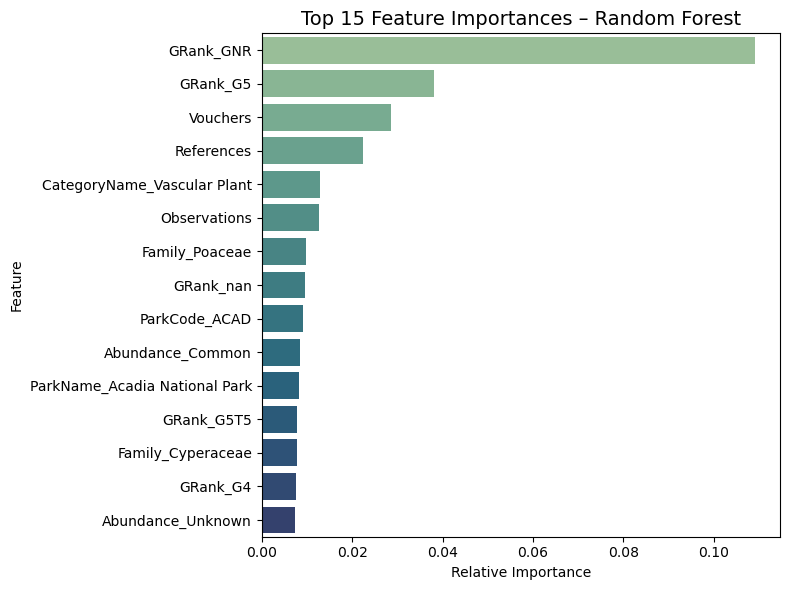

,Feature,Importance
29209,GRank_GNR,0.109160
29159,GRank_G5,0.038097
29226,Vouchers,0.028507
29224,References,0.022416
43,CategoryName_Vascular Plant,0.012803
29225,Observations,0.012582
807,Family_Poaceae,0.009734
29221,GRank_nan,0.009669
0,ParkCode_ACAD,0.009047
29056,Abundance_Common,0.008413


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay


# --- Feature Importance Plot ---
# Extract feature names after preprocessing
encoder = pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_features = encoder.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([cat_features, numeric_cols])

importances = pipe.named_steps["rf"].feature_importances_
fi_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Importance", y="Feature",
    data=fi_df.head(15), palette="crest"
)
plt.title("Top 15 Feature Importances – Random Forest", fontsize=14)
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


fi_df.head(15)


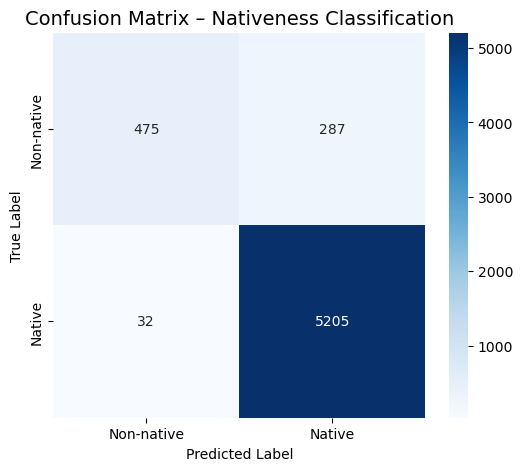

In [43]:
# Confusion Matrix Heatmap 
cm = confusion_matrix(y_test, y_pred)
labels = ["Non-native", "Native"]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels
)
plt.title("Confusion Matrix – Nativeness Classification", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()